In [1]:
%load_ext autoreload
%autoreload 2

# load environment variables
import os
from dotenv import load_dotenv, find_dotenv
dotenv_path = find_dotenv()
load_dotenv(dotenv_path)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sqlalchemy import create_engine

from src.functions.io import ModuleFileReader
from src import queries
scripts = ModuleFileReader(queries)

In [2]:
engine = create_engine(os.environ.get("DATABASE_URL"))

## Seasonality Analysis

In [3]:
films_w_genres = pd.read_sql_query(scripts.read("films_join_hot_genres.sql"), engine)
films_w_genres.set_index(pd.DatetimeIndex(films_w_genres.released), inplace=True)
films_w_genres.head()

,id,title,released,rated,award_noms,award_wins,oscar_noms,oscar_wins,ratings_imdb,ratings_tomatoes,...,sci-fi,biography,fantasy,animation,adventure,family,sport,western,documentary,musical
released,,,,,,,,,,,,,,,,,,,,,
2018-01-05,1,Insidious: The Last Key,2018-01-05,PG-13,0,0,0,0,5.7,32.0,...,0,0,0,0,0,0,0,0,0,0
2018-01-12,5,The Commuter,2018-01-12,PG-13,0,0,0,0,6.3,57.0,...,0,0,0,0,0,0,0,0,0,0
2018-01-12,6,Proud Mary,2018-01-12,R,0,0,0,0,4.9,28.0,...,0,0,0,0,0,0,0,0,0,0
2018-01-12,8,Freak Show,2018-01-12,N/A,0,0,0,0,6.3,51.0,...,0,0,0,0,0,0,0,0,0,0
2018-01-19,12,12 Strong,2018-01-19,R,0,0,0,0,6.6,52.0,...,0,0,0,0,0,0,0,0,0,0


Looking at horror first:

In [4]:
films2010plus = films_w_genres[films_w_genres.index.year > 2009]

In [5]:
years = sorted(list(films2010plus.index.year.unique()))
years

[2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]

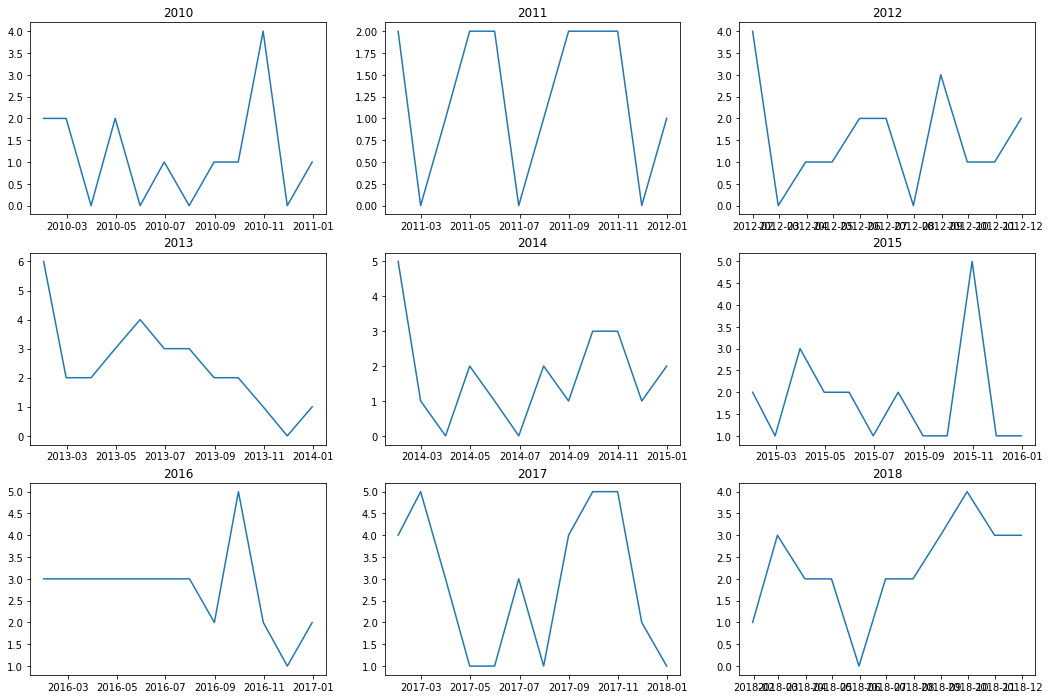

In [6]:
plt.figure(figsize=(18,12))
for ix, year in enumerate(years):
    plt.subplot(3,3,ix + 1)
    films_that_year = films2010plus[films2010plus.index.year == year]
    horror_films = films_that_year[films_that_year.horror == 1]
    monthly = horror_films.resample('M').count()['title']
    plt.plot(monthly.index, monthly.values)
    plt.title(str(year))

- Trend near the end of the year, september/october/november
- 2011 had very few horror films

In [7]:
holidays = pd.read_sql_query(scripts.read('holidays.sql'), engine)
holidays.set_index(pd.DatetimeIndex(holidays.date), inplace=True)
holidays.drop('date', axis=1, inplace=True)

No handles with labels found to put in legend.


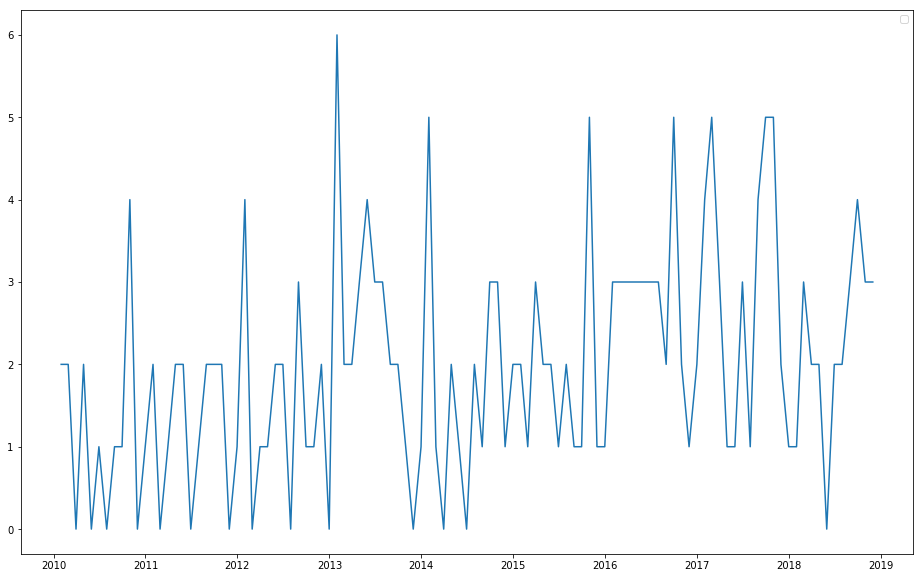

In [8]:
plt.figure(figsize=(16,10))

films2018 = films2010plus
horror_films = films2018[films2018.horror == 1]
monthly = horror_films.resample('M').count()['title']

# holidays2018 = holidays[holidays.index.year == 2018]
# for ix, holiday in zip(holidays2018.index, holidays2018.holiday):
#     plt.scatter(ix, 2, label=holiday)

plt.plot(monthly.index, monthly.values)
plt.legend()

seasonality for film releases in general

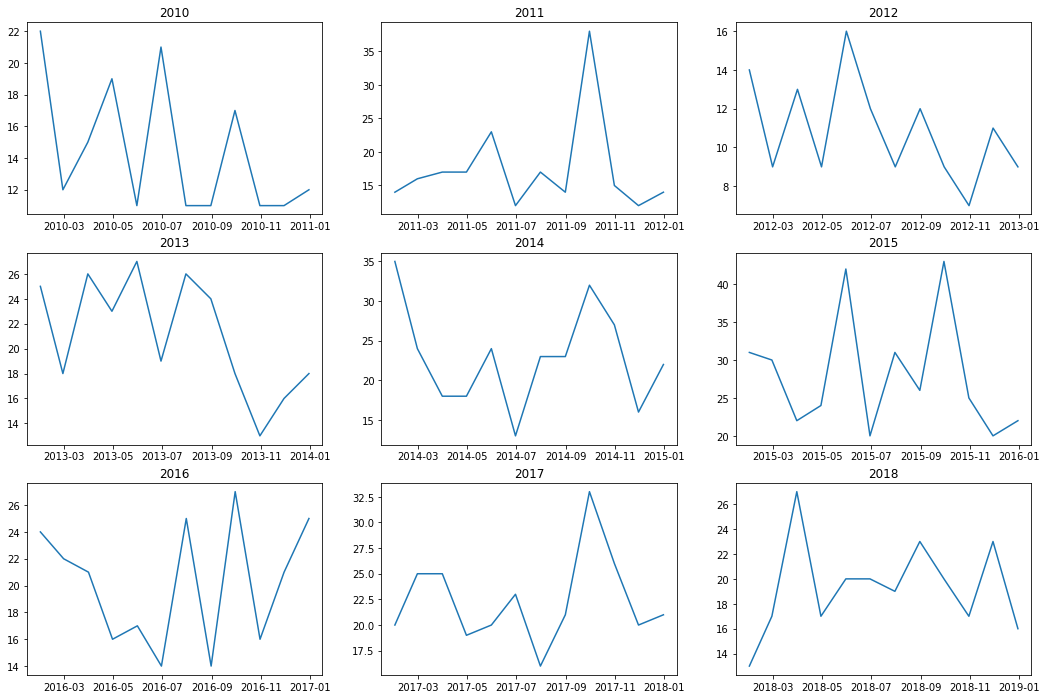

In [9]:
plt.figure(figsize=(18,12))
for i,x in enumerate(years):
    plt.subplot(3,3,i + 1)
    films_that_year = films2010plus[films2010plus.index.year == x]
    monthly = films_that_year.resample('M').count()['title']
    plt.plot(monthly.index, monthly.values)
    plt.title(str(x))

- November seems to be a pretty dry month for movies across most years, except for 2014
- No clear pattern of general seasonality however, summer months aren't always huge release periods as thought

## Normalized horror films per year

In [10]:
horror_films = films2010plus[films2010plus.horror == 1]

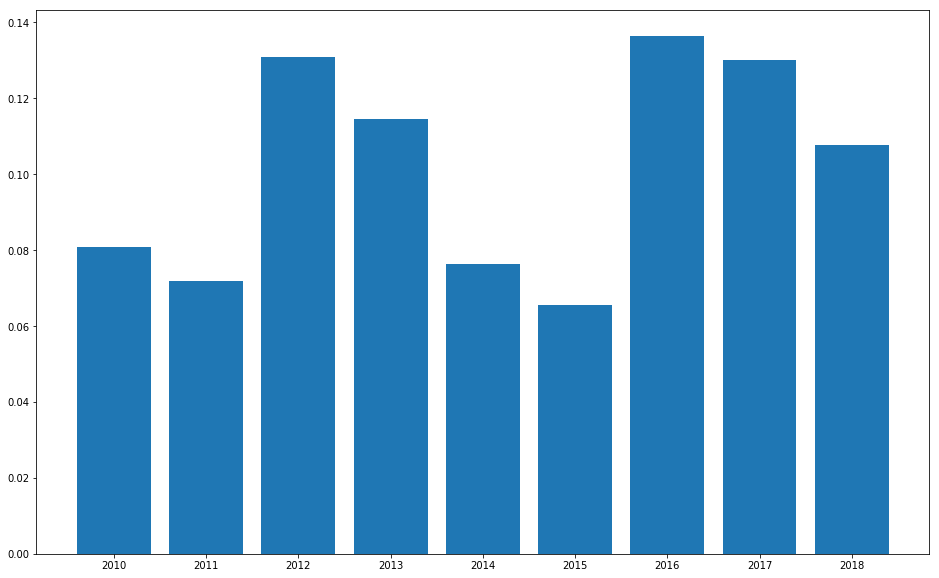

In [11]:
plt.figure(figsize=(16,10))
horror_films_per_year = horror_films.groupby(horror_films.index.year).count()['title']
total_films_per_year = films2010plus.groupby(films2010plus.index.year).count()['title']
norm_horror_per_year = horror_films_per_year / total_films_per_year
plt.bar(norm_horror_per_year.index, norm_horror_per_year.values)
plt.xticks(years)
plt.show()

- At most, horror seems to represent ~10% of total films released each year.
- Between 7-10%

## Normalized total grosses for Horror Films

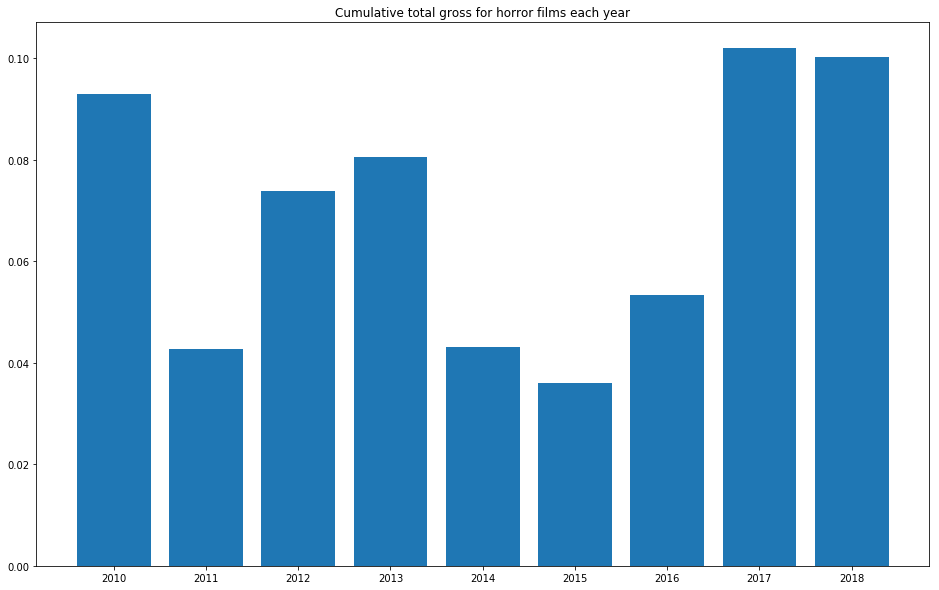

In [12]:
horror_total_grosses = horror_films.groupby(horror_films.index.year).sum()['total_gross']
total_year_grosses = films2010plus.groupby(films2010plus.index.year).sum()['total_gross']
normalized_horror_grosses = horror_total_grosses/total_year_grosses

plt.figure(figsize=(16,10))
plt.bar(normalized_horror_grosses.index, normalized_horror_grosses.values)
plt.xticks(years)
plt.title("Cumulative total gross for horror films each year")
plt.show()

## Genre Metrics Breakdown

Success criteria: budget, awards, ratings, total gross, ROI, windows, opening weekend

In [13]:
# to get rid of scientific notation
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [15]:
genre_metrics = pd.read_sql_query(scripts.read("genre_metrics.sql"), engine)

In [16]:
genre_metrics

,id,title,rated,genre,runtime,budget,total_gross,award_noms,award_wins,oscar_noms,oscar_wins,ratings_imdb,ratings_meta,ratings_tomatoes,domestic_gross,foreign_gross,domestic_pct,foreign_pct,roi
0,1,Insidious: The Last Key,PG-13,Horror,103,10000000.000,167885588.000,0,0,0,0,5.700,49.000,32.000,67745330.000,100140258.000,0.404,0.596,15.789
1,1,Insidious: The Last Key,PG-13,Mystery,103,10000000.000,167885588.000,0,0,0,0,5.700,49.000,32.000,67745330.000,100140258.000,0.404,0.596,15.789
2,1,Insidious: The Last Key,PG-13,Thriller,103,10000000.000,167885588.000,0,0,0,0,5.700,49.000,32.000,67745330.000,100140258.000,0.404,0.596,15.789
3,5,The Commuter,PG-13,Mystery,105,40000000.000,200900000.000,0,0,0,0,6.300,56.000,57.000,36343858.000,83598529.000,0.181,0.416,4.022
4,5,The Commuter,PG-13,Thriller,105,40000000.000,200900000.000,0,0,0,0,6.300,56.000,57.000,36343858.000,83598529.000,0.181,0.416,4.022
5,5,The Commuter,PG-13,Drama,105,40000000.000,200900000.000,0,0,0,0,6.300,56.000,57.000,36343858.000,83598529.000,0.181,0.416,4.022
6,5,The Commuter,PG-13,Action,105,40000000.000,200900000.000,0,0,0,0,6.300,56.000,57.000,36343858.000,83598529.000,0.181,0.416,4.022
7,5,The Commuter,PG-13,Crime,105,40000000.000,200900000.000,0,0,0,0,6.300,56.000,57.000,36343858.000,83598529.000,0.181,0.416,4.022
8,6,Proud Mary,R,Thriller,89,14000000.000,21800000.000,0,0,0,0,4.900,35.000,28.000,20877013.000,876352.000,0.958,0.040,0.557
9,6,Proud Mary,R,Action,89,14000000.000,21800000.000,0,0,0,0,4.900,35.000,28.000,20877013.000,876352.000,0.958,0.040,0.557


### Simple counts

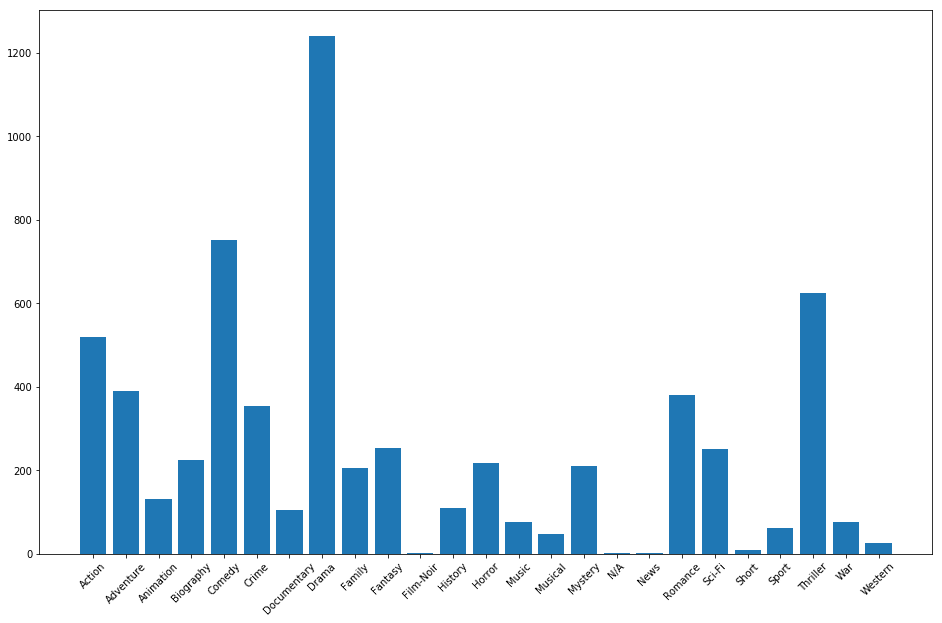

In [17]:
genre_counts = genre_metrics.groupby('genre').count()['id']
plt.figure(figsize=(16,10))

plt.bar(genre_counts.index, genre_counts)
plt.xticks(rotation=45)
plt.show()

- Barely any shorts, westerns, film-noir, news, N/A genres
- Drama is a pretty big bucket, half of all films are drama

### Looking at summary stats of each genre

In [18]:
genre_means = genre_metrics.groupby(genre_metrics.genre).mean()
genre_medians = genre_metrics.groupby(genre_metrics.genre).median()
genre_max = genre_metrics.groupby(genre_metrics.genre).max()
genre_min = genre_metrics.groupby(genre_metrics.genre).min()
genre_std = genre_metrics.groupby(genre_metrics.genre).std()

In [19]:
genre_means.columns

Index(['id', 'runtime', 'budget', 'total_gross', 'award_noms', 'award_wins',
       'oscar_noms', 'oscar_wins', 'ratings_imdb', 'ratings_meta',
       'ratings_tomatoes', 'domestic_gross', 'foreign_gross', 'domestic_pct',
       'foreign_pct', 'roi'],
      dtype='object')

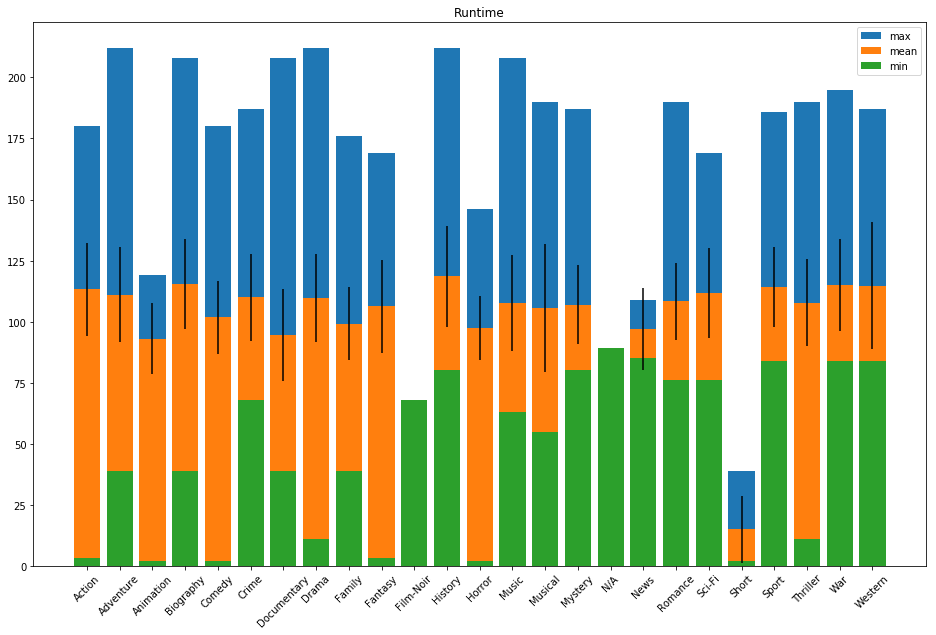

In [20]:
plt.figure(figsize=(16,10))

plt.bar(genre_means.index, genre_max.runtime, label='max')
plt.bar(genre_means.index, genre_means.runtime, label='mean', yerr=genre_std.runtime)
plt.bar(genre_means.index, genre_min.runtime, label='min')
plt.xticks(rotation=45)
plt.title('Runtime')
plt.legend()
plt.show()

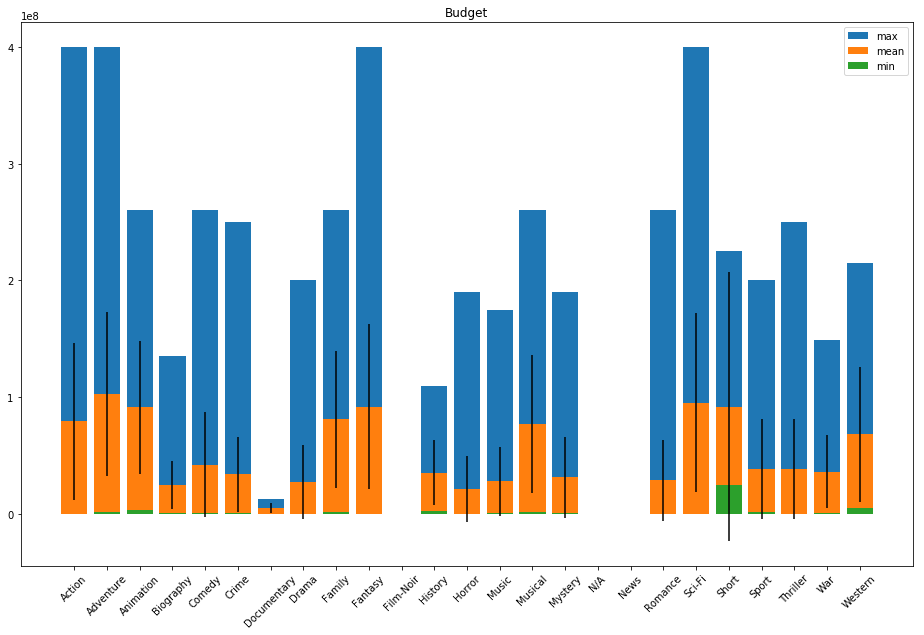

In [21]:
plt.figure(figsize=(16,10))

plt.bar(genre_means.index, genre_max.budget, label='max')
plt.bar(genre_means.index, genre_means.budget, label='mean', yerr=genre_std.budget)
plt.bar(genre_means.index, genre_min.budget, label='min')
plt.xticks(rotation=45)
plt.title('Budget')
plt.legend()
plt.show()

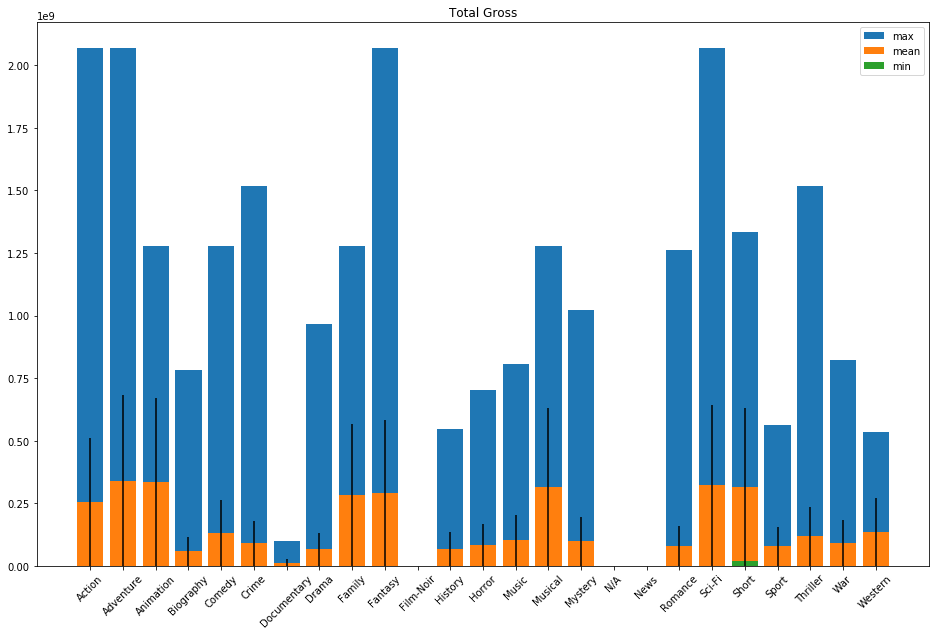

In [22]:
plt.figure(figsize=(16,10))

plt.bar(genre_means.index, genre_max.total_gross, label='max')
plt.bar(genre_means.index, genre_means.total_gross, label='mean', yerr=genre_means.total_gross)
#plt.bar(genre_means.index, genre_medians.total_gross, label='median')
plt.bar(genre_means.index, genre_min.total_gross, label='min')
plt.xticks(rotation=45)
plt.title('Total Gross')
plt.legend()
plt.show()

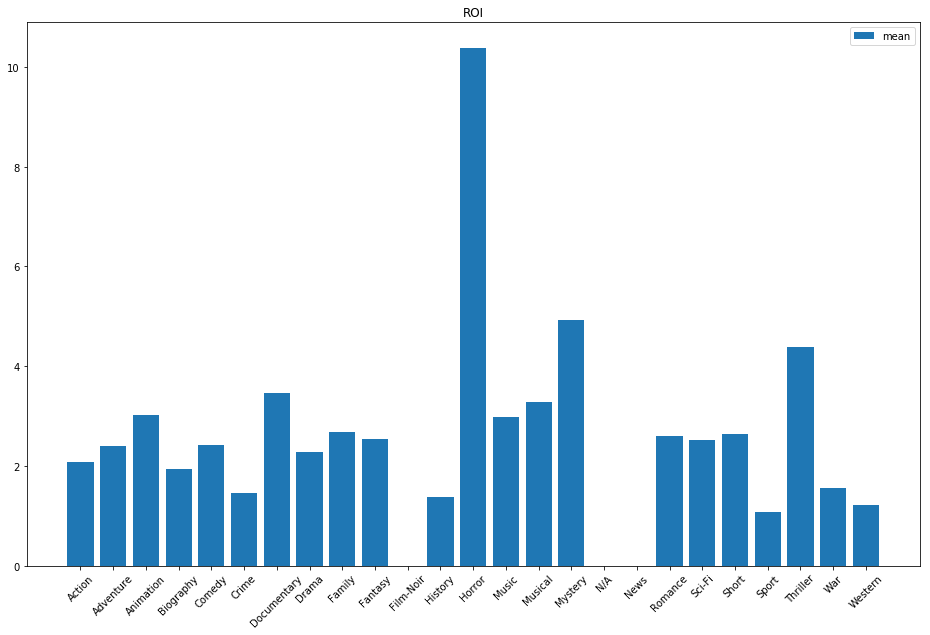

In [23]:
plt.figure(figsize=(16,10))

plt.bar(genre_means.index, genre_means.roi, label='mean')
# plt.bar(genre_medians.index, genre_medians.roi, label='median')

plt.xticks(rotation=45)
plt.title('ROI')
plt.legend()
plt.show()

In [24]:
genre_means.roi

genre
Action         2.074
Adventure      2.407
Animation      3.026
Biography      1.950
Comedy         2.417
Crime          1.468
Documentary    3.458
Drama          2.279
Family         2.690
Fantasy        2.548
Film-Noir        nan
History        1.371
Horror        10.374
Music          2.986
Musical        3.277
Mystery        4.921
N/A              nan
News             nan
Romance        2.592
Sci-Fi         2.518
Short          2.639
Sport          1.085
Thriller       4.376
War            1.558
Western        1.214
Name: roi, dtype: float64

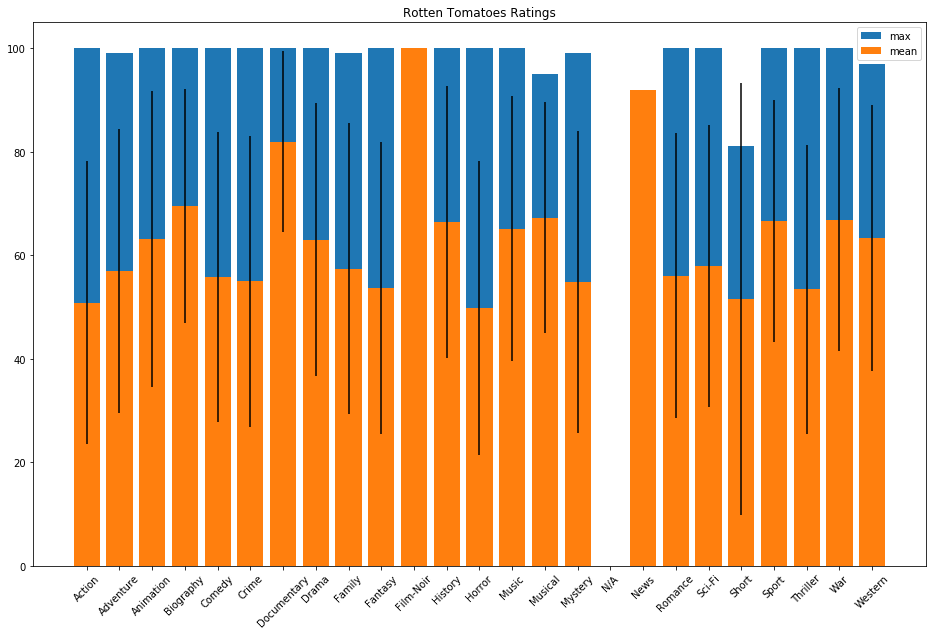

In [25]:
plt.figure(figsize=(16,10))

plt.bar(genre_means.index, genre_max.ratings_tomatoes, label='max')
plt.bar(genre_means.index, genre_means.ratings_tomatoes, label='mean', yerr=genre_std.ratings_tomatoes)
#plt.bar(genre_means.index, genre_medians.total_gross, label='median')
#plt.bar(genre_means.index, genre_min.ratings_tomatoes, label='min')
plt.xticks(rotation=45)
plt.title('Rotten Tomatoes Ratings')
plt.legend()
plt.show()

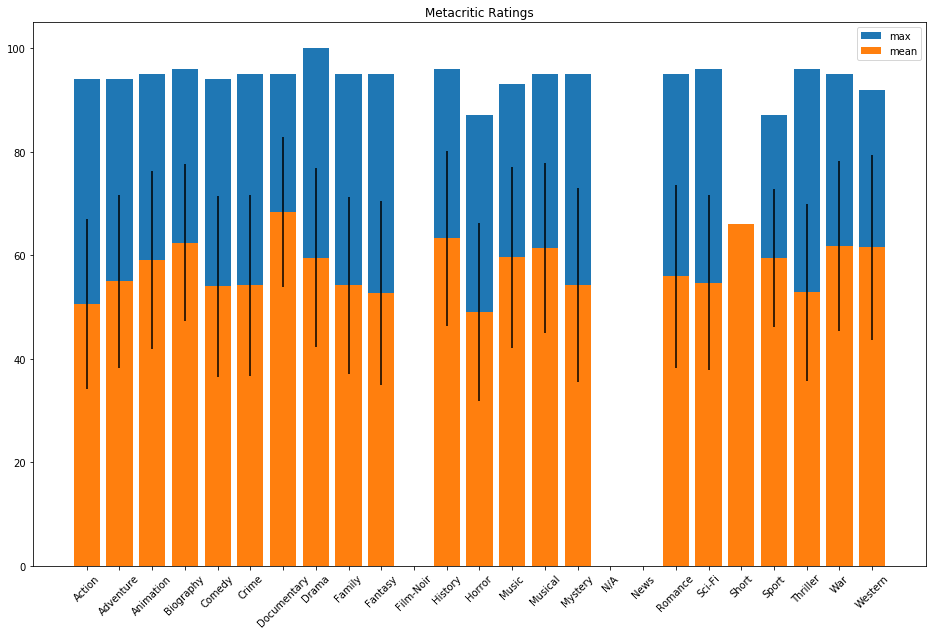

In [26]:
plt.figure(figsize=(16,10))

plt.bar(genre_means.index, genre_max.ratings_meta, label='max')
plt.bar(genre_means.index, genre_means.ratings_meta, label='mean', yerr=genre_std.ratings_meta)
#plt.bar(genre_means.index, genre_medians.total_gross, label='median')
#plt.bar(genre_means.index, genre_min.ratings_tomatoes, label='min')
plt.xticks(rotation=45)
plt.title('Metacritic Ratings')
plt.legend()
plt.show()

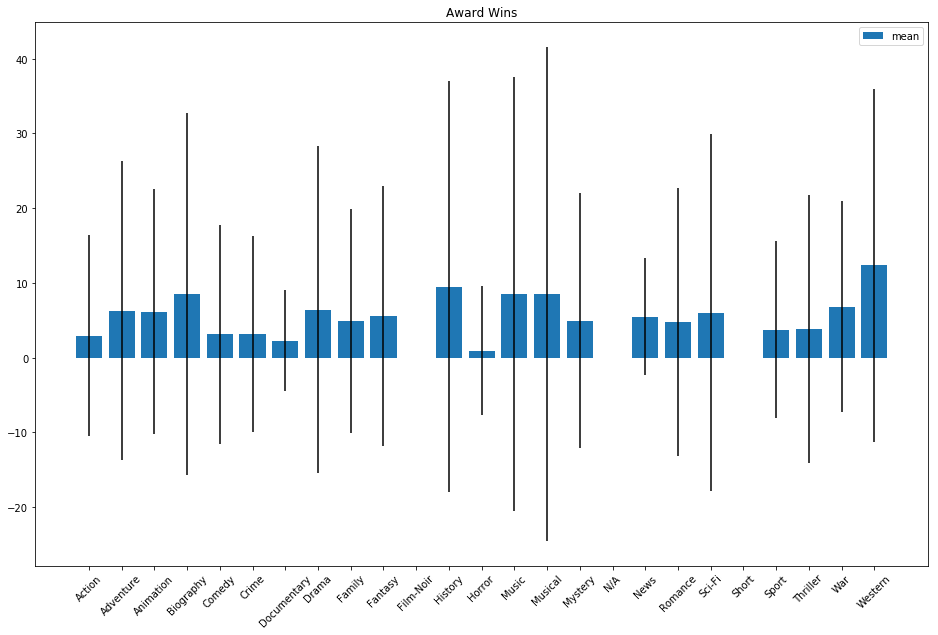

In [27]:
plt.figure(figsize=(16,10))

#plt.bar(genre_means.index, genre_max.award_wins, label='max')
plt.bar(genre_means.index, genre_means.award_wins, label='mean', yerr=genre_std.award_wins)
#plt.bar(genre_means.index, genre_medians.total_gross, label='median')
#plt.bar(genre_means.index, genre_min.ratings_tomatoes, label='min')
plt.xticks(rotation=45)
plt.title('Award Wins')
plt.legend()
plt.show()

In [28]:
genre_std.award_wins

genre
Action        13.446
Adventure     20.050
Animation     16.408
Biography     24.231
Comedy        14.657
Crime         13.143
Documentary    6.778
Drama         21.883
Family        15.000
Fantasy       17.411
Film-Noir        nan
History       27.509
Horror         8.617
Music         29.085
Musical       33.061
Mystery       17.045
N/A              nan
News           7.778
Romance       17.894
Sci-Fi        23.861
Short          0.000
Sport         11.856
Thriller      17.928
War           14.115
Western       23.636
Name: award_wins, dtype: float64

- Horror doesn't win many awards, lower std

## Do critic ratings affect success metrics for horror films as much as other films?

Look for correlations

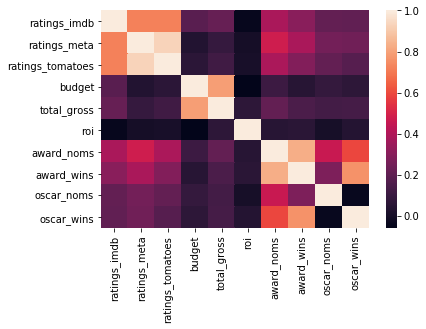

In [29]:
film_metrics = genre_metrics.groupby('title').mean()
critics_vs_metrics_cols = ['ratings_imdb', 'ratings_meta', 'ratings_tomatoes',
                           'budget', 'total_gross', 'roi', 'award_noms',
                           'award_wins','oscar_noms', 'oscar_wins']
critics_vs_metrics = film_metrics[critics_vs_metrics_cols]

sns.heatmap(critics_vs_metrics.corr())

In [30]:
critics_vs_metrics.corr()

,ratings_imdb,ratings_meta,ratings_tomatoes,budget,total_gross,roi,award_noms,award_wins,oscar_noms,oscar_wins
ratings_imdb,1.000,0.722,0.719,0.187,0.219,-0.040,0.386,0.305,0.213,0.208
ratings_meta,0.722,1.000,0.930,0.038,0.094,0.002,0.481,0.387,0.255,0.245
ratings_tomatoes,0.719,0.930,1.000,0.062,0.121,0.008,0.388,0.289,0.211,0.177
budget,0.187,0.038,0.062,1.000,0.792,-0.059,0.110,0.052,0.086,0.067
total_gross,0.219,0.094,0.121,0.792,1.000,0.068,0.211,0.151,0.128,0.132
roi,-0.040,0.002,0.008,-0.059,0.068,1.000,0.052,0.061,0.005,0.044
award_noms,0.386,0.481,0.388,0.110,0.211,0.052,1.000,0.833,0.465,0.592
award_wins,0.305,0.387,0.289,0.052,0.151,0.061,0.833,1.000,0.276,0.764
oscar_noms,0.213,0.255,0.211,0.086,0.128,0.005,0.465,0.276,1.000,-0.035
oscar_wins,0.208,0.245,0.177,0.067,0.132,0.044,0.592,0.764,-0.035,1.000


- In general, it doesn't seem like reviews have much of an impact on ROI or total gross
- IMDB ratings and award nominations seem to be the best indicators of total gross, but very weak
- A films budget is strongly correlated to its total gross, but this intuitively makes sense. More money invested means the film is of a higher calibur/bigger production and is expected to make more \$$$ back

Text(0.5, 1.0, 'Correlation Matrix of Selected Horror Metrics')

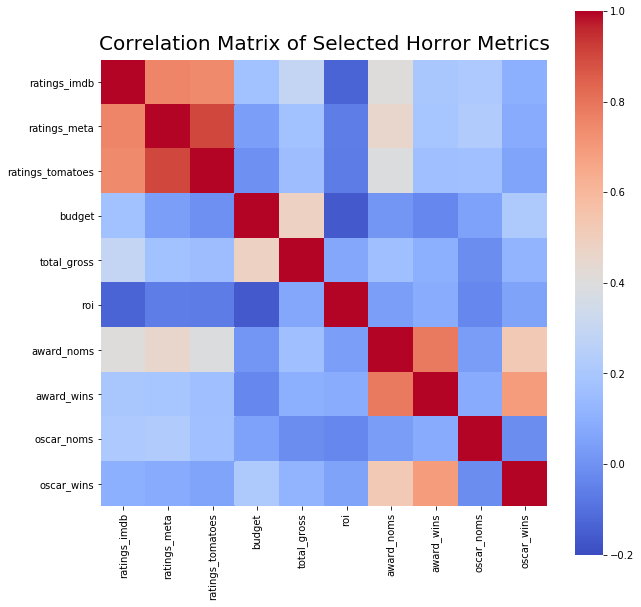

In [31]:
plt.figure(figsize=(10,10))
horror_metrics = genre_metrics[genre_metrics.genre == 'Horror']
horror_critics_vs_metrics = horror_metrics[critics_vs_metrics_cols]
sns.heatmap(horror_critics_vs_metrics.corr(), square=True, cmap='coolwarm', vmin=-0.2)
plt.title("Correlation Matrix of Selected Horror Metrics", pad=10, fontsize=20)

In [32]:
horror_critics_vs_metrics.corr()

,ratings_imdb,ratings_meta,ratings_tomatoes,budget,total_gross,roi,award_noms,award_wins,oscar_noms,oscar_wins
ratings_imdb,1.000,0.759,0.745,0.171,0.295,-0.131,0.408,0.194,0.209,0.098
ratings_meta,0.759,1.000,0.906,0.040,0.171,-0.061,0.454,0.192,0.224,0.084
ratings_tomatoes,0.745,0.906,1.000,-0.007,0.154,-0.064,0.392,0.164,0.167,0.059
budget,0.171,0.040,-0.007,1.000,0.487,-0.160,0.015,-0.035,0.051,0.214
total_gross,0.295,0.171,0.154,0.487,1.000,0.070,0.163,0.101,-0.016,0.118
roi,-0.131,-0.061,-0.064,-0.160,0.070,1.000,0.043,0.090,-0.035,0.055
award_noms,0.408,0.454,0.392,0.015,0.163,0.043,1.000,0.785,0.038,0.527
award_wins,0.194,0.192,0.164,-0.035,0.101,0.090,0.785,1.000,0.083,0.691
oscar_noms,0.209,0.224,0.167,0.051,-0.016,-0.035,0.038,0.083,1.000,-0.013
oscar_wins,0.098,0.084,0.059,0.214,0.118,0.055,0.527,0.691,-0.013,1.000


- imdb ratings matter 12% more than other review metrics, weak correlation to total gross
- budget is less indicative of a higher total gross in horror than in general, and has a slight negative corr to roi

**in general it seems that critic reviews don't have much of an impact on films' total gross or ROIs.**

In [ ]:
genres_one_hot = pd.read_sql_query(scripts.read("genres_one_hot.sql"), engine)

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(genres_one_hot.corr(), square=True)

- Horror is moderately correlated with mystery/thriller
- Animation is strongly correlated with family, adventure, fantasy
- Drama is defined in OMDB in a way that it is mostly mutually exclusive of action, adventure

# Comparing means of horror and non-horror films

**Come back to later for hypothesis tests**

In [ ]:
genre_financials = pd.read_sql_query(scripts.read("genre_financials.sql"), engine)

In [ ]:
horror = genre_financials[genre_financials.genre == 'Horror']
horror_ids = horror.id.values
non_horror = genre_financials[~genre_financials.id.isin(horror_ids)].groupby('id').mean()

In [ ]:
horror.mean()['roi']

In [ ]:
non_horror.mean()['roi']

likelihood ratios
- t test for means

In [ ]:
non_horror

In [ ]:
genre_means[['ratings_imdb', 'ratings_meta', 'ratings_tomatoes']]

In [ ]:
genre_means